In [1]:
%reset -f
%matplotlib inline

import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
dirToInclude=parentdir +'/features/'
sys.path.insert(0,dirToInclude)


import pandas
import numpy as np
import pandas as pd
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
from sklearn.cross_validation import StratifiedKFold, ShuffleSplit, cross_val_score, train_test_split
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

import scipy as sp
import theano.tensor as t

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
data = pd.read_csv("../Data/cns_data.csv")
rf_results = pd.read_csv("Outputs/rf_results.csv")

In [27]:
var = rf_results
#Keep only what we are using
var = var.loc[:,['CMalaria','Enceph','Mening','Other',\
                      'headache','age','temp','date',\
                      'clinjaund','clintonsil','clinhepato','clinaids','clinhemmor','clinorcand','clinearinf',\
                      'clinresp','clinlymph','clindehyd','clinoedem','clinablung','clincyan','clincapref',\
                      'glasgtot', 'dbp', 'sbp','resp','card','weight','height','muac',\
                      'mhhosp','mhchronstat', 'mhdevsp',\
                      'conv','abdpain','vom','diar','muscle','monthday',\
                       'incirrit', 'inchead', 'incphoto',\
                      'incfont', 'incneuro' , 'incseiza', 'incseizh',\
                      'incpurp','diag']]
var = var.dropna()
var.shape

(361, 48)

In [71]:
y = var['diag']
y[y==5] = 2
y[y==4] = 2
y[y==3] = 2
#x = var[['CMalaria','Mening','Enceph','glasgtot','sbp']]
x = var[['CMalaria','sbp','glasgtot','dbp','resp','card','weight','height','muac']]

In [72]:
with pm.Model() as logistic_model:
    μ = pm.Normal('μ', 0, sd=10)
    effects = pm.Normal('effects', mu=0, sd=10, shape=(x.shape[1], 3))
    
    # expected parameter
    p = pm.math.invlogit(μ + t.dot(x, effects))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Categorical('Y_obs', p=p, observed=y)

with logistic_model:
    trace = pm.sample(1000, tune=400, njobs=2, nuts_kwargs={'target_accept':0.99})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [effects, μ]
Sampling 2 chains: 100%|██████████| 2800/2800 [09:49<00:00,  2.78draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.940648534292797, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


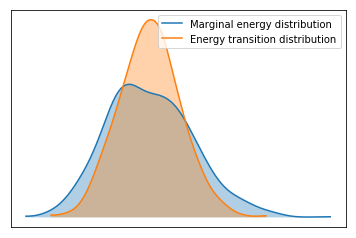

In [82]:
pm.energyplot(trace)

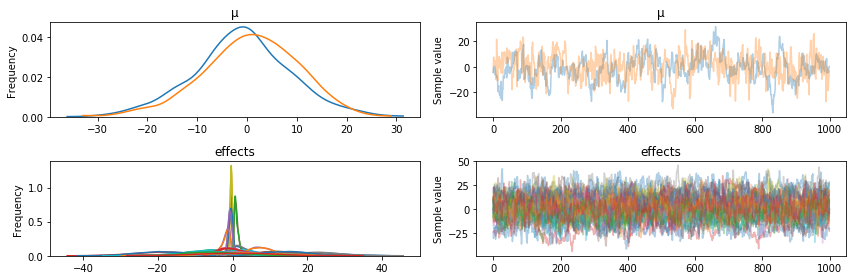

In [74]:
pm.traceplot(trace);

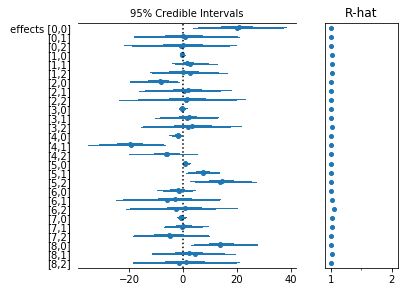

In [75]:
pm.forestplot(trace, varnames=['effects'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x13ad3cbe0>,
      dtype=object)

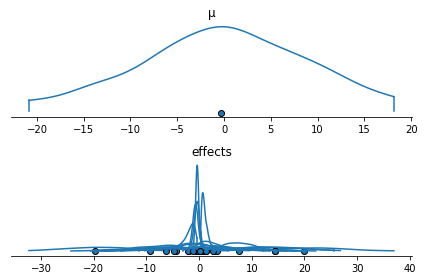

In [76]:
pm.plots.densityplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x139cffd30>,
      dtype=object)

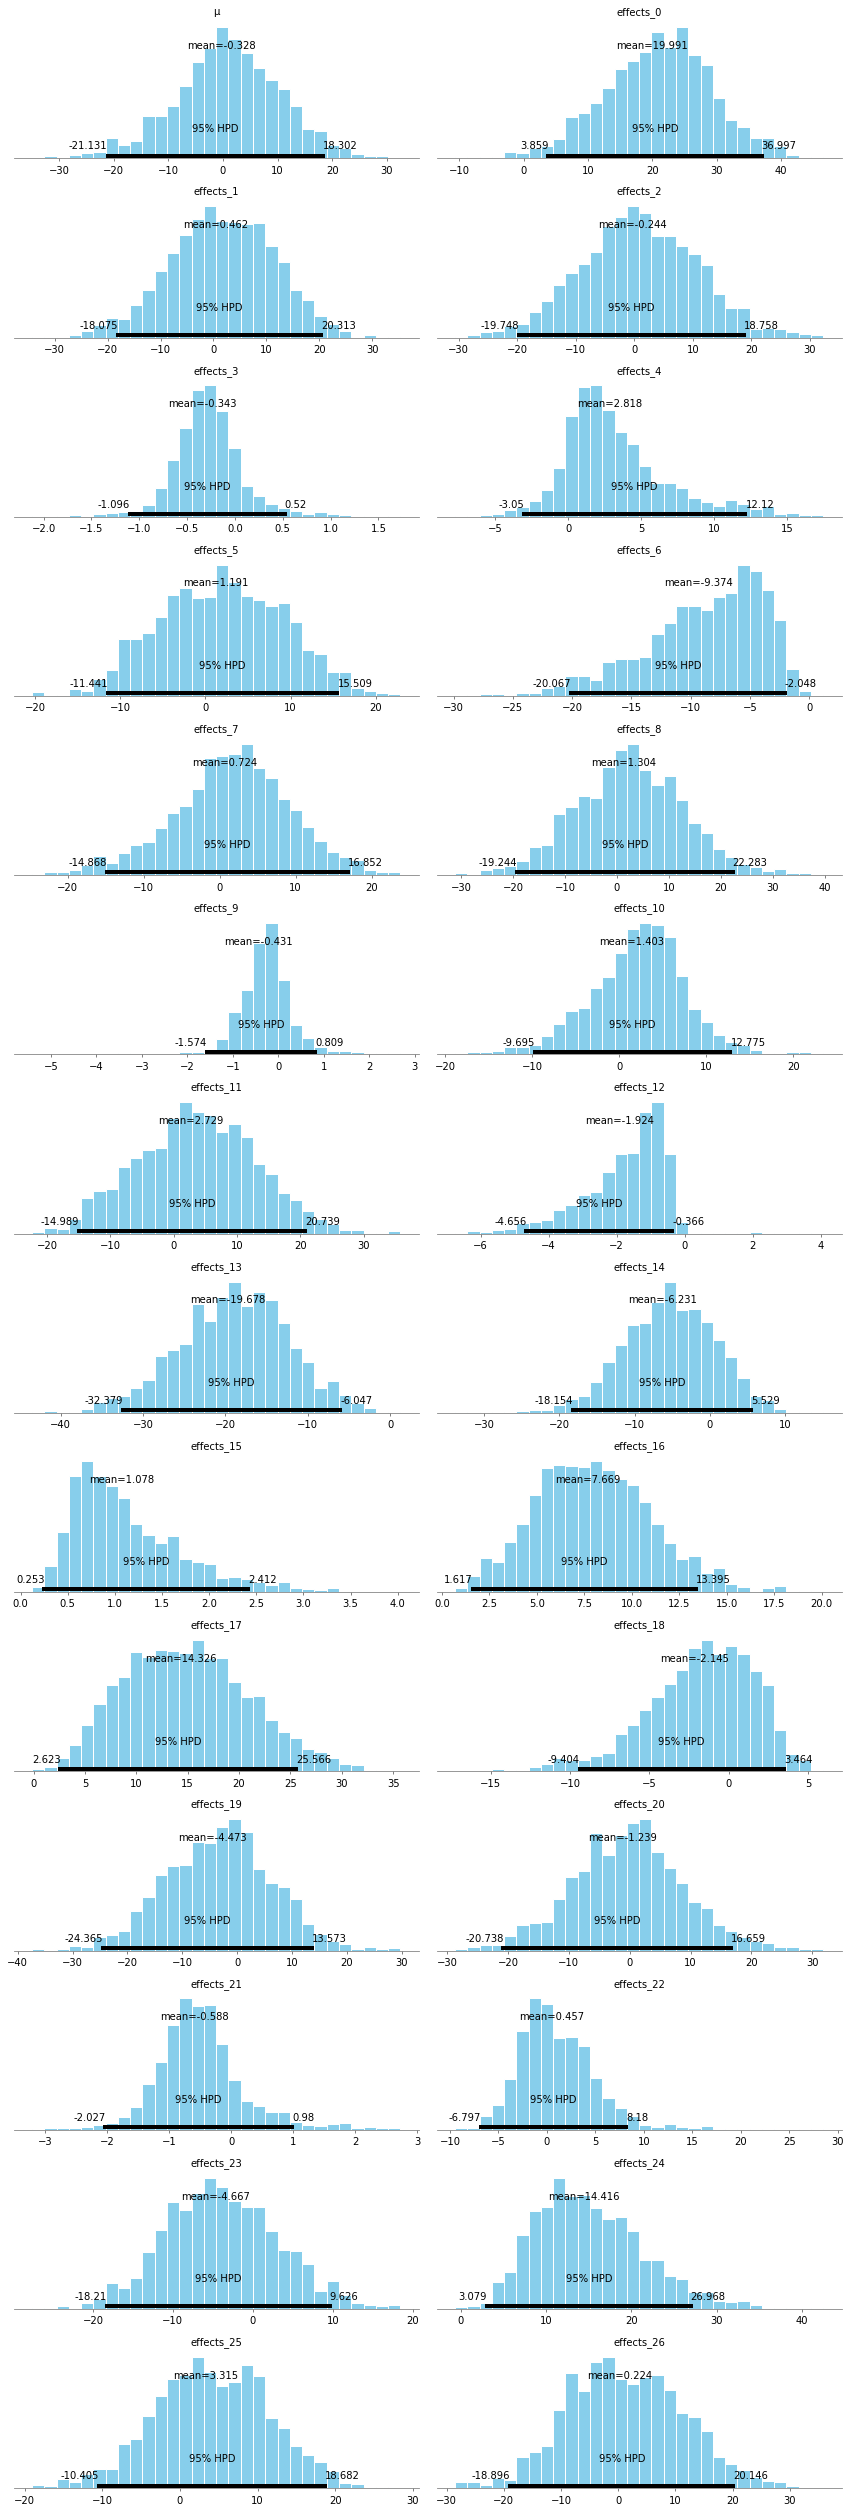

In [77]:
pm.plots.plot_posterior(trace)

In [78]:
ppc = pm.sample_ppc(trace, samples=500, model=logistic_model)

100%|██████████| 500/500 [00:14<00:00, 35.28it/s]


In [79]:
ppc['Y_obs'].shape

(500, 361, 1)

<Container object of 3 artists>

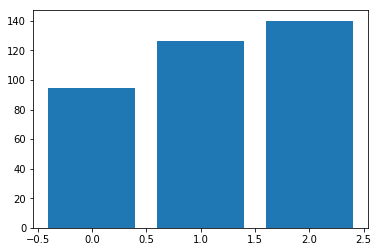

In [80]:
plt.bar([0,1,2], height=[
    np.asscalar(sum(sum(ppc['Y_obs'] == 0)))/500,
    np.asscalar(sum(sum(ppc['Y_obs'] == 1)))/500,
    np.asscalar(sum(sum(ppc['Y_obs'] == 2)))/500], width=0.8)

<Container object of 3 artists>

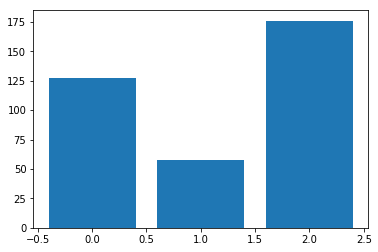

In [81]:
plt.bar([0,1,2], height=[sum(y==0),sum(y==1),sum(y==2)], width=0.8,)

In [16]:
effects_posterior = pm.summary(trace, varnames=['effects'])

In [17]:
effects_posterior['mean'].values.reshape(5, 3)

array([[ 7.02738752e+00, -2.54413804e+00, -2.26868187e+00],
       [-5.64142223e+00,  6.92179658e-01,  3.57724112e+00],
       [-5.51464319e+00, -1.55885696e+00,  3.91606227e+00],
       [-1.24060011e-02,  1.34344226e-01,  2.29824038e-01],
       [-2.23969074e-02, -3.92795299e+00,  2.08831471e-03]])

In [54]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
μ,-2.85,7.61,0.41,-18.14,14.75,44.74,1.00
effects__0_0,4.50,8.51,0.44,-13.70,20.39,11.68,1.09
effects__0_1,0.53,6.96,0.26,-14.67,16.63,548.68,1.02
effects__0_2,-0.31,9.40,0.30,-17.73,18.75,923.52,1.00
effects__1_0,3.29,9.32,0.40,-15.23,22.56,14.89,1.08
effects__1_1,2.58,8.06,0.41,-14.71,19.37,21.91,1.07
effects__1_2,-0.39,10.22,0.31,-19.05,20.13,1199.28,1.00
effects__2_0,2.35,8.05,0.40,-14.82,18.95,166.61,1.03
effects__2_1,1.01,6.99,0.26,-15.42,15.28,647.10,1.01
effects__2_2,-1.97,10.84,0.57,-23.29,18.28,32.14,1.03


In [ ]:
pm.traceplot(effect[])


In [35]:
x.shape[1]

47

In [36]:
effects

effects

In [92]:
sum(x["CMalaria"])

143.0

Questions:
    Abstract
    How to create probabilistic output for individual predictions
    Is sensitivity/specificity a decent metric, what about unsureness?